# やりたいこと

- S&P500と有名な高配当投資信託の相関を計算する
    - 単純相関は，色々分析されているが，トレンドと変動を分離して変動の相関を取りたい

In [1]:
import toml
import pandas as pd
import datetime
import copy
import numpy as np

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
labels = [  'VOO'  # S&P500 連動 ETF
          , 'SPYD' # S&P500 高配当株式 ETF
          , 'VYM'  # バンガード米国高配当株式 ETF
          , 'SCHD' # シュワブ米国高配当株式 ETF
          , 'VT'   # バンガード・トータル・ワールドストックETF
          , 'GLD'  # SDPRゴールドシェア
         ]

In [3]:
tickers = {key: yf.Ticker(key) for key in labels}
data = {}
for key,ticker in tickers.items():
    datum = ticker.history(start='2000-01-01', end='2025-01-01')
    datum.index = datum.index.tz_localize(None)
    data[key] = datum
close_list = []
dividends_list = []
key_list = []
for key, datum in data.items():
    close_list.append(datum['Close'])
    dividends_list.append(datum['Dividends'])
    key_list.append(key)
close_df = pd.concat(close_list, axis=1, join='inner')
close_df.columns = key_list

dividends_df = pd.concat(dividends_list, axis=1, join='inner')
dividends_df.columns = key_list

In [4]:
relative_close_df = close_df/close_df.loc[close_df.index[0]]
relative_div_df = dividends_df/close_df.loc[close_df.index[0]]
relative_div_cumsum_df = relative_div_df.cumsum()
#relative_close_df.plot()
#relative_div_df.plot()
#relative_div_cumsum_df.plot()

# ここからやること

- [x] 各時系列毎にトレンドを分離するために seasonal_decompose などを利用する
    - [x] 周期を決めるためにgroupbyでレコード数をカウントする
- [x] トレンドとの残差成分の相関を計算する
- [x] 分配金追加のリターンも計算する
- [x] 分配金再投資のリターンも計算する

## キャピタルゲイン+分配金累計額 (非投資)

In [5]:
# 分配金追加のリターン
relative_close_and_div = relative_close_df+relative_div_cumsum_df
#relative_close_and_div.plot()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [6]:
# 分配金有無の確認
relative_div_df.sum()

VOO     0.310676
SPYD    0.772348
VYM     0.533663
SCHD    0.344347
VT      0.346171
GLD     0.000000
dtype: float64

## 分配金再投資

### テストコード

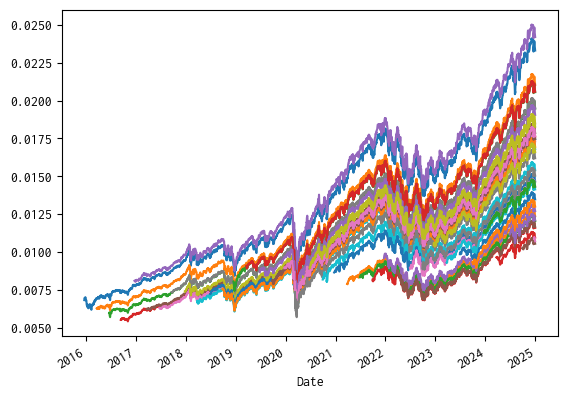

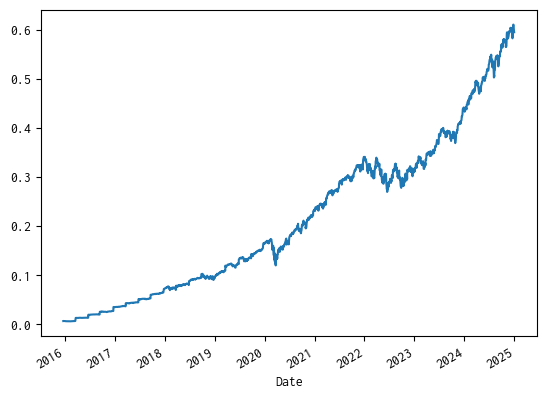

In [22]:
# 分配金再投資のテスト
key = 'VOO'
divs = {}
for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
    divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
for dt in divs.keys():
    divs[dt].plot()
plt.show()
plt.close('all')

# 分配金再投資の合計のテスト
key = 'VOO'
divs = {}
for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
    divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
pd.DataFrame(divs).sum(axis=1).plot()
plt.show()
plt.close('all')

### 分配金再投資系列の作成

<Axes: >

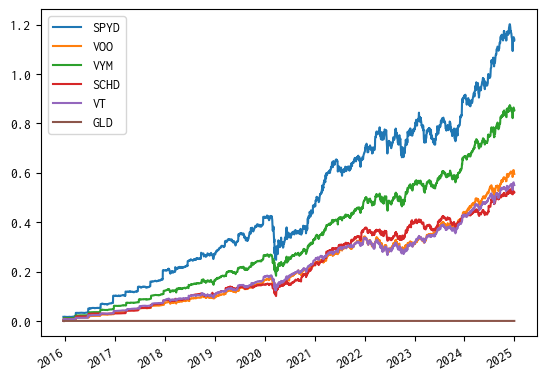

In [8]:
temporal_data = {}
for key in key_list:
    divs = {}
    # 分配金受取時の基準価額を1.0とした相対価額時系列に分配金を乗算する
    for dt,divid in relative_div_df[relative_div_df[key]!=0][key].items():
        divs[dt] = close_df[close_df.index>=dt][key]/close_df[key][dt]*divid
    # 分配金受取時ごとの系列をDataFrame型に変換し全て加算する
    temporal_data[key] = pd.DataFrame(divs).sum(axis=1)
# 分配金運用額のみのデータ
divid_reinvest_df = pd.DataFrame({key:value for key, value in sorted(temporal_data.items(), key=lambda x: min(x[1].index) if x[1].size > 0 else datetime.datetime(2099,1,1))}).fillna(0)
divid_reinvest_df.plot()

<Axes: >

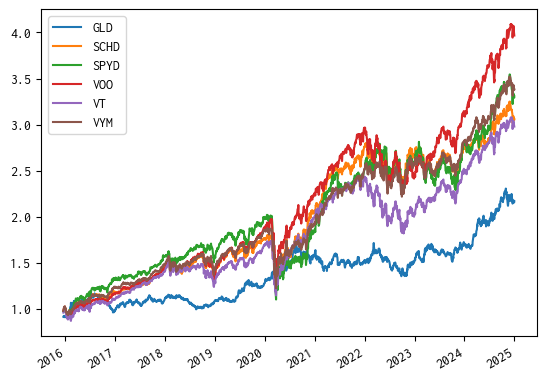

In [9]:
# キャピタルゲイン+分配金
relative_close_and_div_reinvest = relative_close_df + divid_reinvest_df
relative_close_and_div_reinvest.plot()

# ここからやること

トレンドは同じく右上がりだが，季節性や残差が無相関の系列を探したい

- [ ] 分配金再投資系列を，集計範囲のみに削ってから，元のETF相対時系列に足したトータルリターンのグラフを作成する
- [x] 分配金再投資系列をトレンドと季節制変動に分解する
- [x] 季節性，残差の相関を計算する
- [ ] 年推移相関係数をプロットする
- [ ] リスク最小化の比率を計算する

In [10]:
trimmed = relative_close_and_div[np.logical_and(relative_close_and_div.index > datetime.datetime(2015,12,31), relative_close_and_div.index < datetime.datetime(2023,1,1))]

## 時系列の季節性分離

In [11]:
voo_anal = seasonal_decompose(trimmed['VOO'], period=251)
spyd_anal = seasonal_decompose(trimmed['SPYD'], period=251)
vym_anal = seasonal_decompose(trimmed['VYM'], period=251)
vt_anal = seasonal_decompose(trimmed['VT'], period=251)
gld_anal = seasonal_decompose(trimmed['GLD'], period=251)

## 形状確認:トレンド，季節性，残差の出力

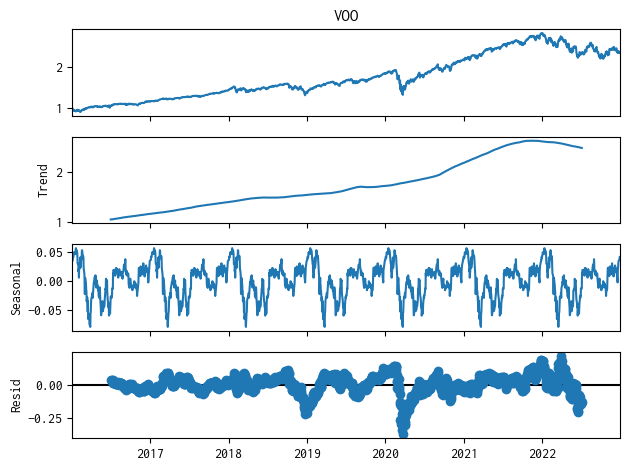

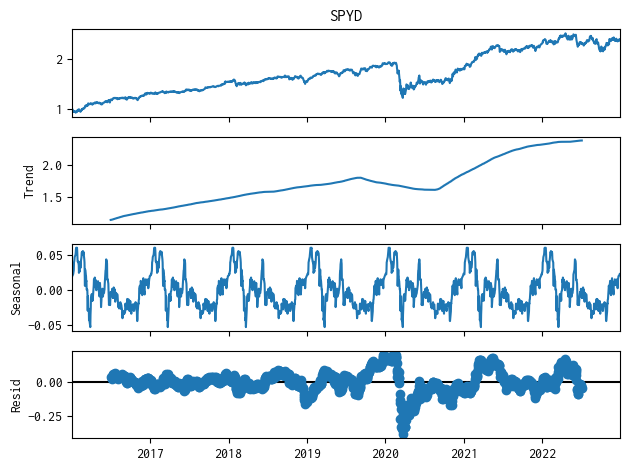

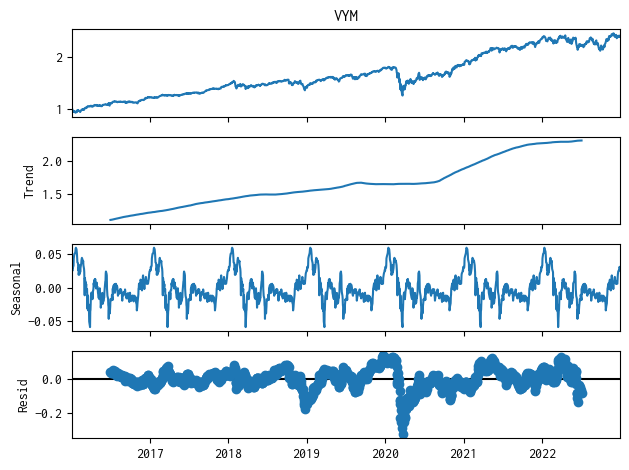

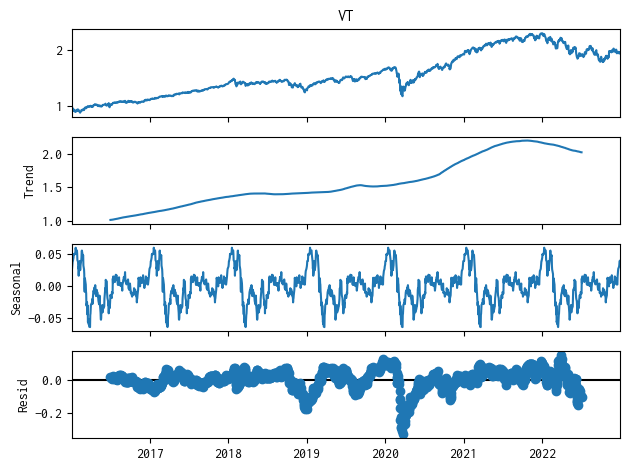

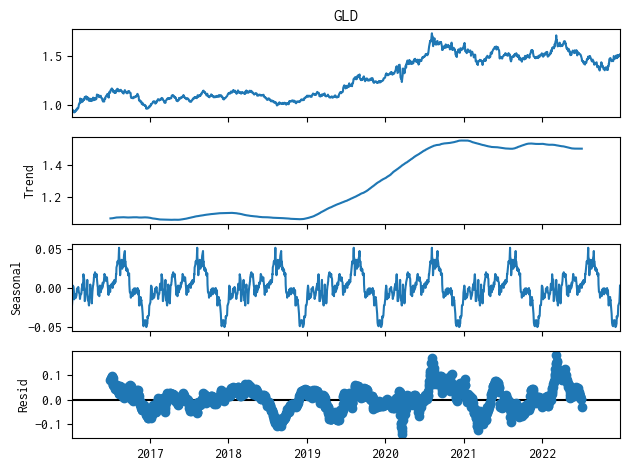

In [12]:
voo_anal.plot()
spyd_anal.plot()
vym_anal.plot()
vt_anal.plot()
gld_anal.plot()
pass

## 時系列そのまま

### ペアプロット

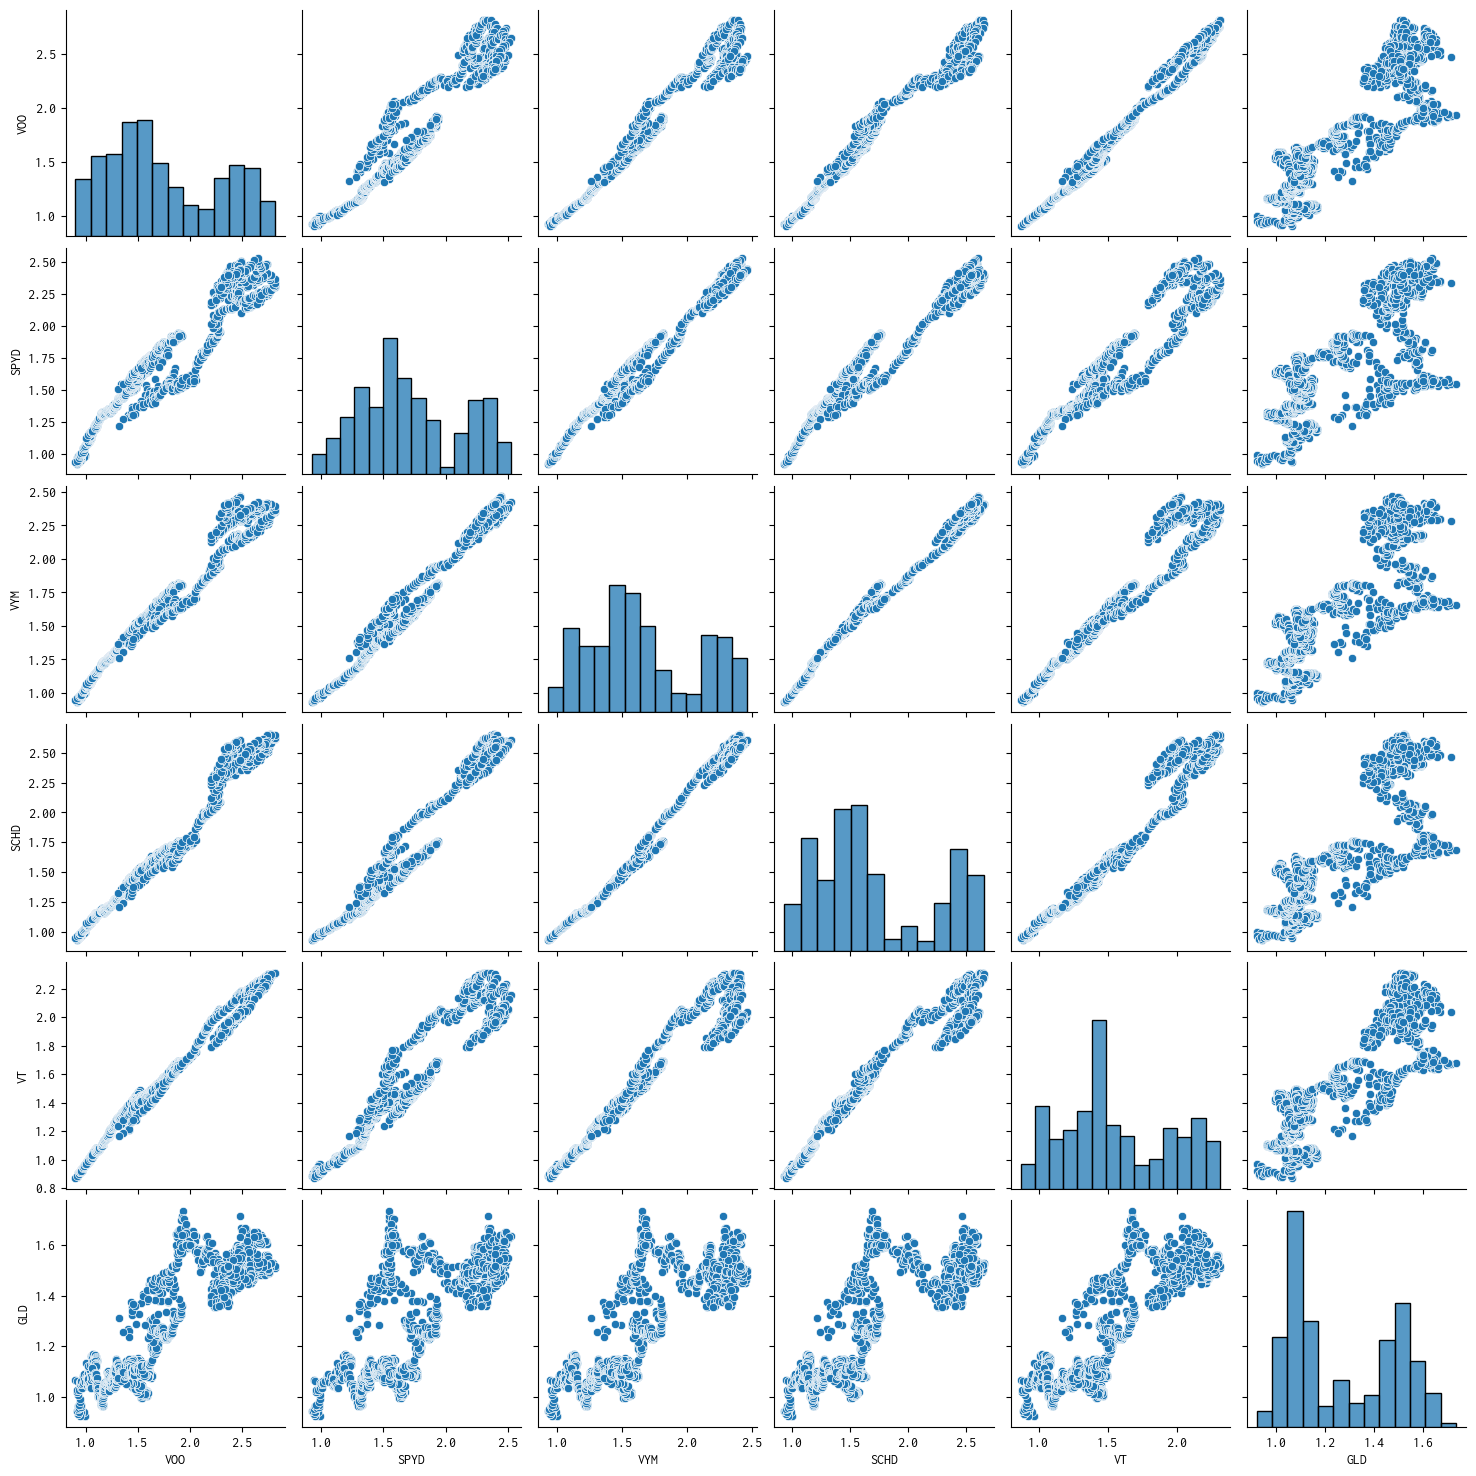

In [13]:
sns.pairplot(trimmed)

### 相関行列

In [14]:
trimmed.corr()

,VOO,SPYD,VYM,SCHD,VT,GLD
VOO,1.000000,0.946269,0.980108,0.987837,0.992827,0.867145
SPYD,0.946269,1.000000,0.986329,0.971837,0.937334,0.724997
VYM,0.980108,0.986329,1.000000,0.993191,0.967368,0.807026
SCHD,0.987837,0.971837,0.993191,1.000000,0.975918,0.824250
VT,0.992827,0.937334,0.967368,0.975918,1.000000,0.848909
GLD,0.867145,0.724997,0.807026,0.824250,0.848909,1.000000


## 季節性成分

### ペアプロット

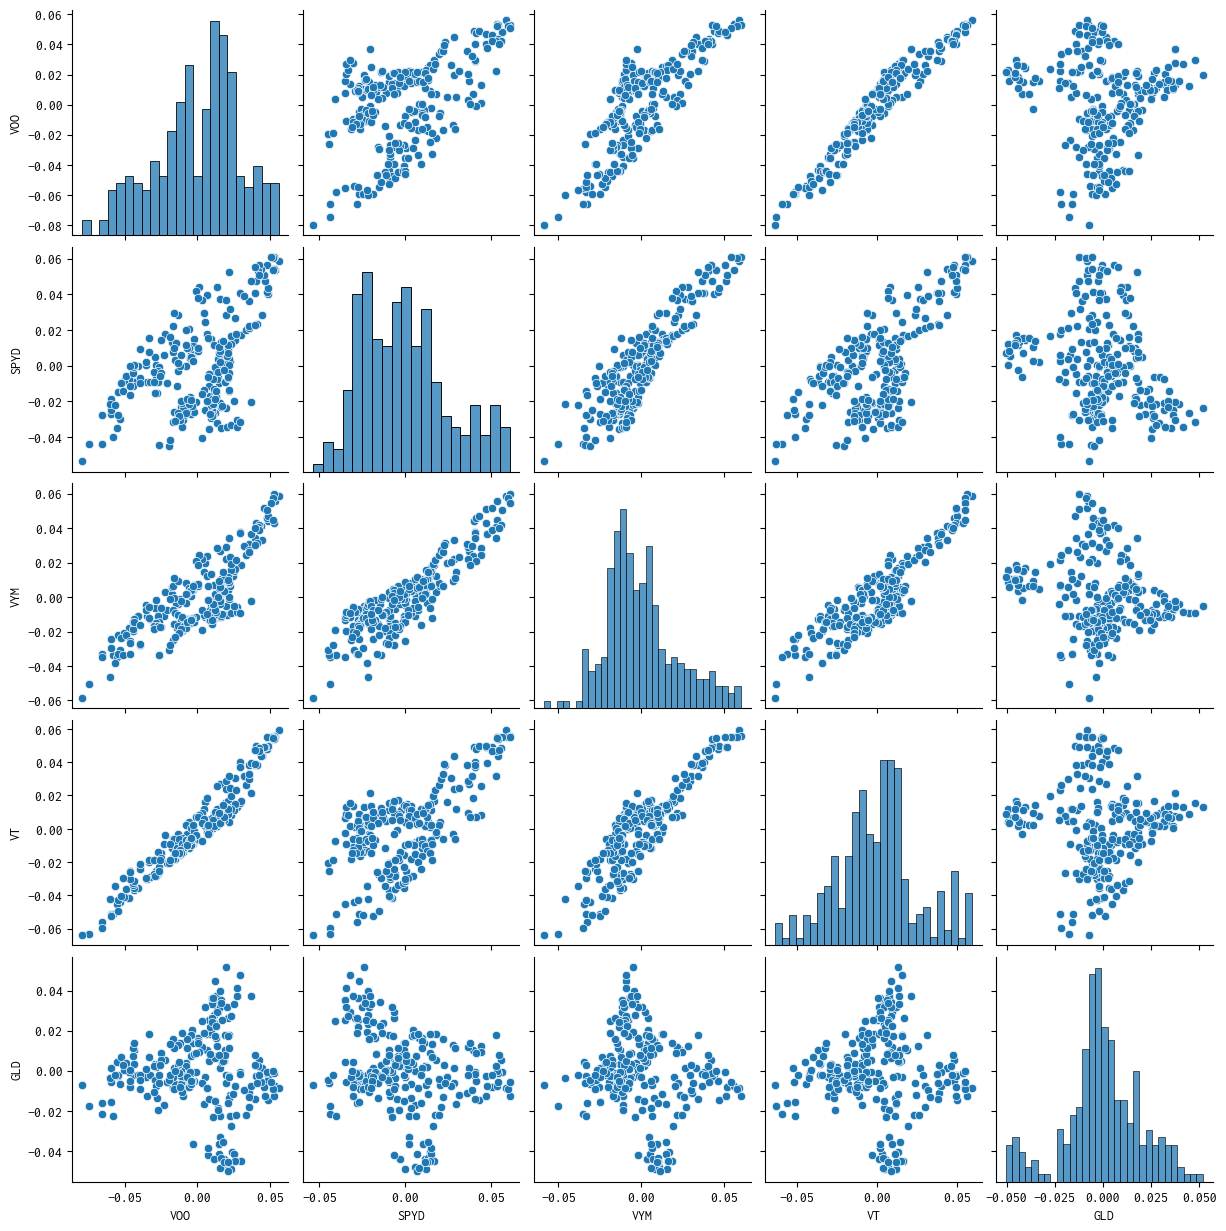

In [17]:
seasonal = pd.DataFrame({'VOO':voo_anal.seasonal, 'SPYD':spyd_anal.seasonal, 'VYM':vym_anal.seasonal, 'VT':vt_anal.seasonal, 'GLD':gld_anal.seasonal})
sns.pairplot(seasonal)

### 相関行列

In [18]:
seasonal.corr()

,VOO,SPYD,VYM,VT,GLD
VOO,1.000000,0.531566,0.818279,0.962523,-0.003071
SPYD,0.531566,1.000000,0.896637,0.669285,-0.253576
VYM,0.818279,0.896637,1.000000,0.886042,-0.165151
VT,0.962523,0.669285,0.886042,1.000000,0.001494
GLD,-0.003071,-0.253576,-0.165151,0.001494,1.000000


## 残差

### ペアプロット

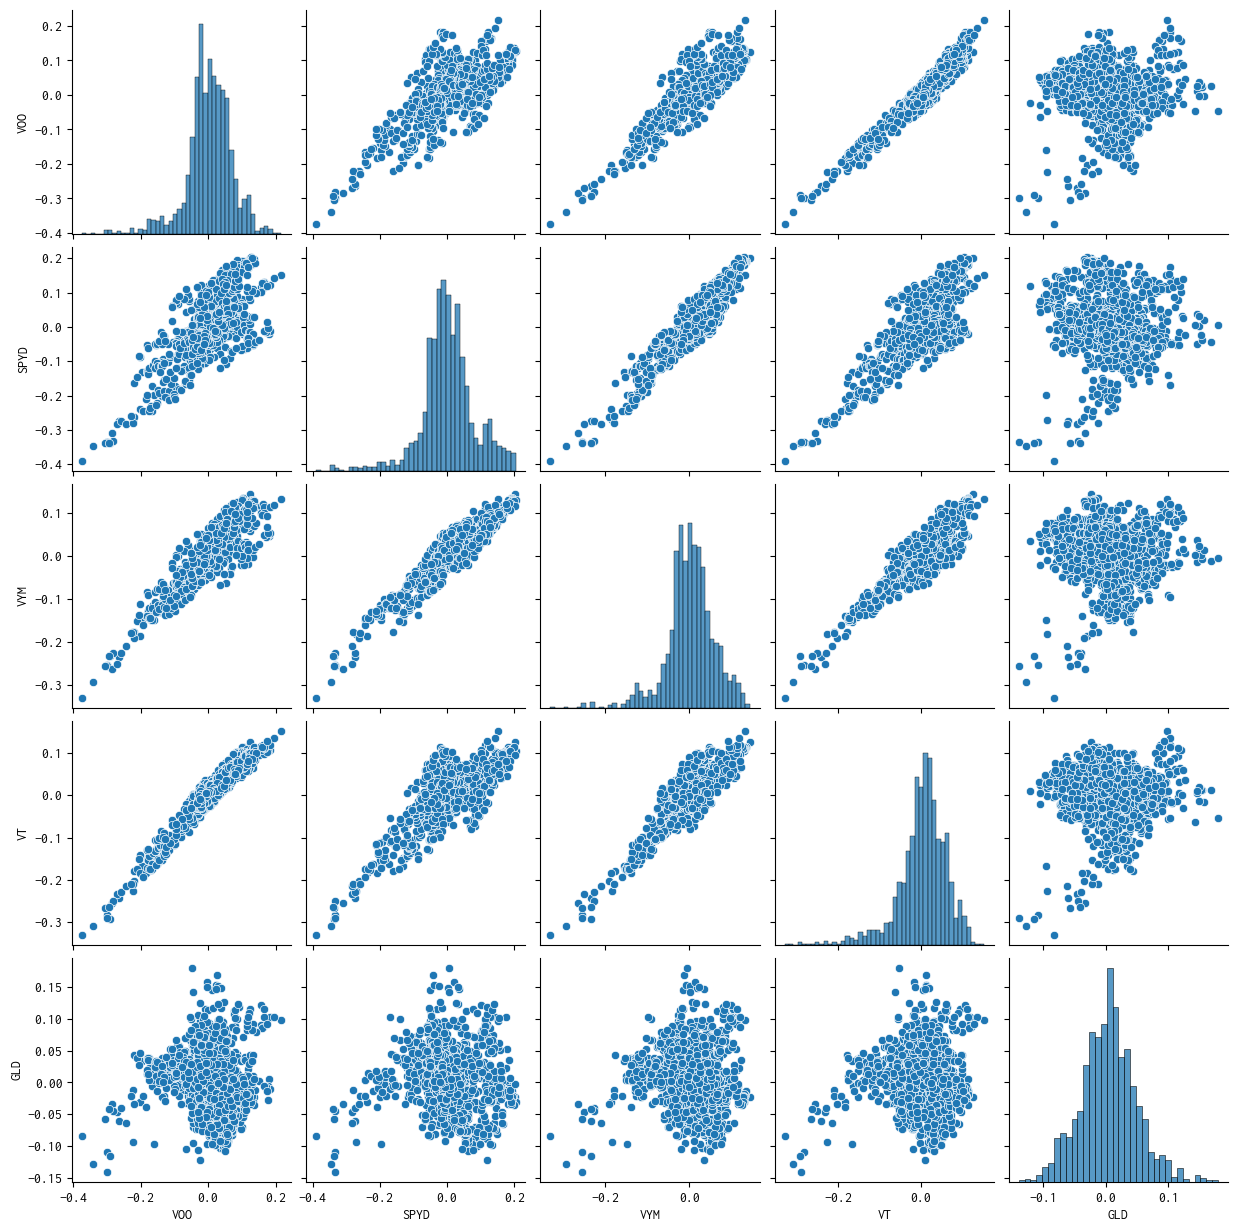

In [21]:
resid = pd.DataFrame({'VOO':voo_anal.resid, 'SPYD':spyd_anal.resid, 'VYM':vym_anal.resid, 'VT':vt_anal.resid, 'GLD':gld_anal.resid})
sns.pairplot(resid)

### 相関行列

In [22]:
resid.corr()

,VOO,SPYD,VYM,VT,GLD
VOO,1.000000,0.708770,0.873427,0.962499,-0.022567
SPYD,0.708770,1.000000,0.938161,0.776087,-0.065471
VYM,0.873427,0.938161,1.000000,0.892691,-0.034851
VT,0.962499,0.776087,0.892691,1.000000,-0.028476
GLD,-0.022567,-0.065471,-0.034851,-0.028476,1.000000


## 季節性+残差 (トレンド成分除去)

### ペアプロット

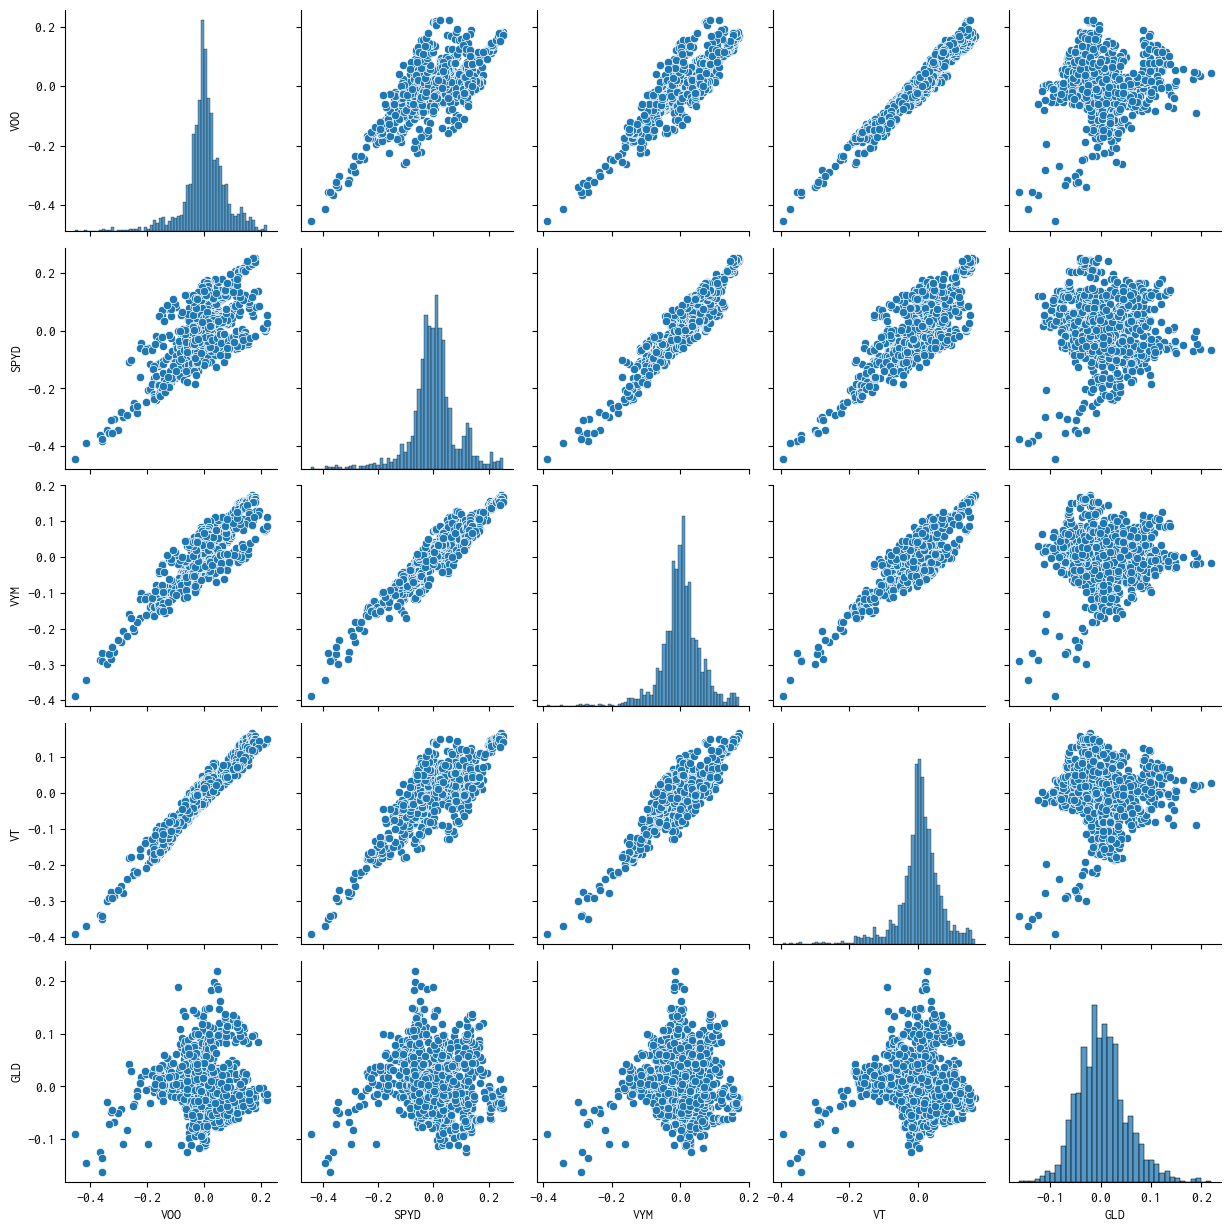

In [23]:
sns.pairplot(seasonal+resid)

### 相関行列

In [24]:
(seasonal+resid).corr()

,VOO,SPYD,VYM,VT,GLD
VOO,1.000000,0.685161,0.865258,0.962474,-0.019297
SPYD,0.685161,1.000000,0.932561,0.760450,-0.087761
VYM,0.865258,0.932561,1.000000,0.891033,-0.052900
VT,0.962474,0.760450,0.891033,1.000000,-0.023571
GLD,-0.019297,-0.087761,-0.052900,-0.023571,1.000000
